### Emulating a SISO MPC with an LSTM Network

The purpose of this exercise is to automate a temperature control process with an LSTM network. The LSTM network is trained from a 1x1 SISO MPC (Single Input Single Output, Model Predictive Control). LSTM (Long Short Term Memory) networks are a special type of RNN (Recurrent Neural Network) that is structured to remember and predict based on long-term dependencies that are trained with time-series data. An LSTM repeating module has four interacting components.

<img align=left width=400px src='https://apmonitor.com/pds/uploads/Main/lstm_mpc_1x1.png'>

The LSTM is trained (parameters adjusted) with an input window of prior data and minimized difference between the predicted and next measured value. Sequential methods predict just one next value based on the window of prior data. In this case, the error between the set point and measured value is the feature and the heater value is the output label.

See [Automation with LSTM Networks](https://apmonitor.com/pds/index.php/Main/LSTMAutomation) for additional details.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm # Progress bar

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

# For Gekko and TCLab
import tclab
from gekko import GEKKO

### Use [TCLab](https://apmonitor.com/heat.htm) Microcontroller or Emulator (Digital Twin)

Change `tclab_hardware` to `True` if TCLab device is connected.

<img width=550px align=left src='https://apmonitor.com/pdc/uploads/Main/tclab_connect.png'>

In [2]:
tclab_hardware = False # True
if tclab_hardware:
    mlab = tclab.TCLab      # Physical hardware
else:
    speedup = 100
    mlab = tclab.setup(connected=False, speedup = speedup) # Emulator

### PID controller 

See [LSTM Network Replaces PID](https://github.com/APMonitor/pds/blob/main/LSTM_Automation.ipynb) for code with a PID controller instead of a Model Predictive Controller (MPC).

### MPC (Model Predictive Control)

See the last example for [MPC with TCLab](https://apmonitor.com/pds/notebooks/12_time_series.html) or the [Linear MPC with TCLab](https://apmonitor.com/do/index.php/Main/TCLabF). This controller is implemented instead of a PID controller. The steps to create an MPC application are:

- generate step test data
- identify model
- initialize controller
- create MPC function to return Q1

**Generate Step Test Data**

TCLab version 0.4.9
Simulated TCLab
Time: 0 Q1: 0.0 Q2: 0.0 T1: 20.95 T2: 20.63
Time: 200 Q1: 80.0 Q2: 35.0 T1: 54.47 T2: 30.62
Time: 400 Q1: 20.0 Q2: 95.0 T1: 51.89 T2: 43.19
Time: 600 Q1: 70.0 Q2: 25.0 T1: 39.64 T2: 39.97
Time: 800 Q1: 70.0 Q2: 100.0 T1: 58.66 T2: 46.09
Time: 1000 Q1: 50.0 Q2: 100.0 T1: 60.27 T2: 54.15
TCLab Model disconnected successfully.


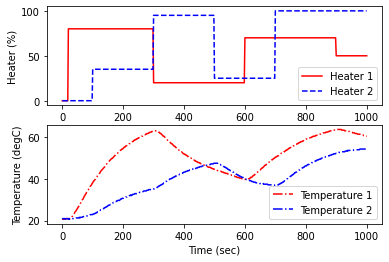

In [3]:
# generate step test data on TCLab
filename = 'tclab_data.csv'

n = 500
tm = np.linspace(0,n*2,n+1)
T1 = np.zeros(n+1)
T2 = np.zeros(n+1)

# heater steps
Q1d = np.zeros(n+1)
Q1d[10:150]=80; Q1d[150:300]=20; Q1d[300:450]=70; Q1d[450:]=50

Q2d = np.zeros(n+1)
Q2d[50:150]=35; Q2d[150:250]=95; Q2d[250:350]=25; Q2d[350:]=100

p1 = 1 if tclab_hardware else 100
# Connect to TCLab
with mlab() as lab:
    # run step test (20 min)
    t1 = time.time()
    for i in range(n+1):
        # set heater values
        lab.Q1(Q1d[i])
        lab.Q2(Q2d[i])
        T1[i] = lab.T1
        T2[i] = lab.T2
        if i%p1==0:
            print('Time: ' + str(2*i) + \
              ' Q1: ' + str(Q1d[i]) + \
              ' Q2: ' + str(Q2d[i]) + \
              ' T1: ' + str(round(T1[i],2)) + \
              ' T2: ' + str(round(T2[i],2)))            

        if tclab_hardware:
            if tm[i]>=(t2-t1):
                time.sleep(max(0,min(2,tm[i]-(t2-t1))))
        else:
            for t in tclab.clock(2, 2):
                continue        

# write data to file
fid = open(filename,'w')
fid.write('Time,Q1,Q2,T1,T2\n')
for i in range(n+1):
    fid.write(str(tm[i])+','+str(Q1d[i])+','+str(Q2d[i])+',' \
              +str(T1[i])+','+str(T2[i])+'\n')
fid.close()
                
# read data file
data = pd.read_csv(filename)

# plot measurements
plt.figure()
plt.subplot(2,1,1)
plt.plot(data['Time'],data['Q1'],'r-',label='Heater 1')
plt.plot(data['Time'],data['Q2'],'b--',label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(data['Time'],data['T1'],'r-.',label='Temperature 1')
plt.plot(data['Time'],data['T2'],'b-.',label='Temperature 2')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('tclab_data.png')
plt.show()

**Identify Model**

Identify model


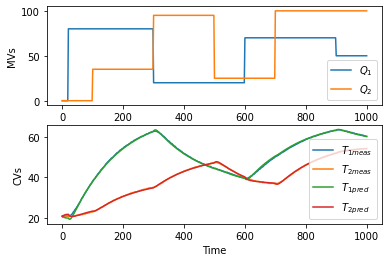

In [4]:
#########################################################
# Initialize Model
#########################################################
# load data and parse into columns
data = pd.read_csv('tclab_data.csv')
t = data['Time']
u = data[['Q1','Q2']]
y = data[['T1','T2']]

# generate time-series model
m = GEKKO(remote=False)

##################################################################
# system identification
na=2; nb=2 # use 2nd order model
print('Identify model')
yp,p,K = m.sysid(t,u,y,na,nb,objf=10000,scale=False,diaglevel=0,pred='model')

##################################################################
# plot sysid results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend([r'$Q_1$',r'$Q_2$'])
plt.ylabel('MVs')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp)
plt.legend([r'$T_{1meas}$',r'$T_{2meas}$',\
            r'$T_{1pred}$',r'$T_{2pred}$'])
plt.ylabel('CVs')
plt.xlabel('Time')
plt.savefig('sysid.png')
plt.show()

**Initialize Controller**

Create 2x2 (2 Heaters, 2 Temperature Sensors) MPC but only use 1x1 (`Q1`, `T1`) for this application. The LSTM learning can be extended to the 2x2 MPC (MVs: `Q1` and `Q2`, CVs: `T1` and `T2`).

In [5]:
##################################################################
# create control ARX model
m = GEKKO(remote=False)
m.y = m.Array(m.CV,2)
m.u = m.Array(m.MV,2)
m.arx(p,m.y,m.u)

# rename CVs
m.TC1 = m.y[0]
m.TC2 = m.y[1]

# rename MVs
m.Q1 = m.u[0]
m.Q2 = m.u[1]

# steady state initialization
m.options.IMODE = 1
m.solve(disp=False)

# set up MPC
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 1 # APOPT
m.time=np.linspace(0,60,31)

# Manipulated variables
m.Q1.STATUS = 1  # manipulated
m.Q1.FSTATUS = 0 # not measured
m.Q1.DMAX = 100.0
m.Q1.DCOST = 2.0
m.Q1.UPPER = 100.0
m.Q1.LOWER = 0.0

m.Q2.STATUS = 0  # manipulated, turn off Q2
m.Q2.FSTATUS = 1 # use measured value
m.Q2.DMAX = 100.0
m.Q2.DCOST = 2.0
m.Q2.UPPER = 100.0
m.Q2.LOWER = 0.0
m.Q2.MEAS = 0    # set Q2=0

# Controlled variables
m.TC1.STATUS = 1     # drive to set point
m.TC1.FSTATUS = 1    # receive measurement
m.TC1.TAU = 8        # response speed (time constant)
m.TC1.TR_INIT = 2    # reference trajectory
m.TC1.TR_OPEN = 5

m.TC2.STATUS = 0     # drive to set point
m.TC2.FSTATUS = 1    # receive measurement
m.TC2.TAU = 8        # response speed (time constant)
m.TC2.TR_INIT = 2    # dead-band
m.TC2.TR_OPEN = 1    # for CV_TYPE=1

In [6]:
def mpc(m,T1,T1sp,T2,T2sp):    
    # Insert measurements
    m.TC1.MEAS = T1
    m.TC2.MEAS = T2

    # Adjust setpoints
    db1 = 1.0 # dead-band
    m.TC1.SP   = T1sp
    m.TC1.SPHI = T1sp + db1
    m.TC1.SPLO = T1sp - db1

    db2 = 0.2
    m.TC2.SP   = T2sp
    m.TC2.SPHI = T2sp + db2
    m.TC2.SPLO = T2sp - db2
    
    # Adjust heaters with MPC
    m.solve(disp=False) 

    if m.options.APPSTATUS == 1:
        # Retrieve new values
        Q1  = m.Q1.NEWVAL
        Q2  = m.Q2.NEWVAL
    else:
        # Solution failed
        Q1  = 0.0
        Q2  = 0.0    
    return [Q1,Q2]

### Generate data for training LSTM

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


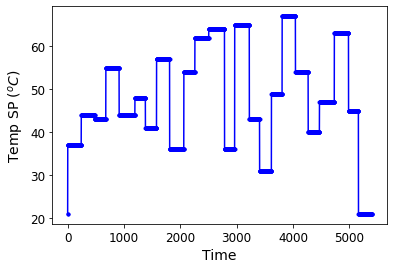

In [7]:
##### Set up run parameters #####
run_time = 90.0 # minutes

loops = int(30.0*run_time+1) # cycles (2 sec each)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
T2 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
Q2 = np.zeros(loops) # Heater values
tm = np.linspace(0,2*(loops-1),loops) # Time

# Temperature set point (degC)
with mlab() as lab:
    Tsp1 = np.ones(loops) * lab.T1
    Tsp2 = np.ones(loops) * lab.T2

# vary temperature setpoint
end = 2 # leave first couple cycles of temp set point as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 3 to 5 min
    end += random.randint(90,150) 
    Tsp1[start:end] = random.randint(30,70)
Tsp1[-120:] = Tsp1[0] # last 4 minutes at room temperature
    
if tclab_hardware:
    # print every cycle with hardware
    p1 = 10; p2 = 1
else:
    # print 20x less with emulator
    p1 = 200; p2 = 20   

# Plot
plt.plot(tm,Tsp1,'b.-')
plt.xlabel('Time',size=14)
plt.ylabel(r'Temp SP ($^oC$)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('SP_profile.png');

### Data Collection

In [8]:
# Data collection
with mlab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    t1 = time.time()
    for i in range(loops):
        t2 = time.time()
        
        if tclab_hardware:
            if tm[i]>=(t2-t1):
                time.sleep(max(0,min(2,tm[i]-(t2-t1))))
        else:
            dt = time.time()-t2
            for t in tclab.clock(2, max(0.1,2-dt)):
                continue
            t2=time.time()
              
        # Read temperatures in Celcius 
        T1[i] = lab.T1; T2[i] = lab.T2

        # Calculate MPC output every 2 sec
        try:
            [Q1[i],Q2[i]] = mpc(m,T1[i],Tsp1[i],T2[i],Tsp2[i])
        except:
            Q1[i] = 0; Q2[i] = 0 # catch any failure to converge
        # Write heater output (0-100)
        lab.Q1(Q1[i])
        lab.Q2(Q2[i])
         
        if i%p1==0:            
            print('  Time_____Q1___Tsp1_____T1______Q2____Tsp2_____T2')
        if i%p2==0:
            print(('{:6.1f} {:6.2f} {:6.2f} {:6.2f}  {:6.2f}  {:6.2f} {:6.2f}').format( \
                      tm[i],Q1[i],Tsp1[i],T1[i],Q2[i],Tsp2[i],T2[i]))

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.95 °C
  Time_____Q1___Tsp1_____T1______Q2____Tsp2_____T2
   0.0   0.00  20.95  20.95    0.00   20.95  20.95
  40.0   7.04  37.00  36.10    0.00   20.95  23.53
  80.0  21.18  37.00  35.45    0.00   20.95  23.21
 120.0  23.74  37.00  35.78    0.00   20.95  23.21
 160.0  26.10  37.00  35.78    0.00   20.95  23.53
 200.0  25.70  37.00  36.10    0.00   20.95  23.21
 240.0  26.29  37.00  36.42    0.00   20.95  23.53
 280.0  31.27  44.00  42.22    0.00   20.95  24.49
 320.0  35.61  44.00  42.87    0.00   20.95  24.49
 360.0  37.97  44.00  42.87    0.00   20.95  24.49
  Time_____Q1___Tsp1_____T1______Q2____Tsp2_____T2
 400.0  37.78  44.00  43.19    0.00   20.95  24.82
 440.0  37.19  44.00  43.51    0.00   20.95  24.49
 480.0  37.67  44.00  43.51    0.00   20.95  24.49
 520.0  36.84  43.00  42.87    0.00   20.95  24.49
 560.0  36.18  43.00  42.87    0.00   20.95  24.49
 600.0  37.15  43.00  42.87    0.00   20.95  24.4

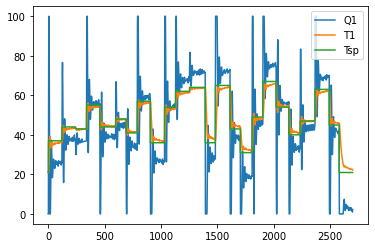

In [9]:
# Save csv file
df = pd.DataFrame()
df['Q1'] = Q1
df['T1'] = T1
df['Tsp'] = Tsp1
df.to_csv('MPC_train_data.csv',index=False)

# Plot
df.plot()
plt.savefig('MPC_train.png');

### Feature engineering: create SP error feature and analyze feature importance

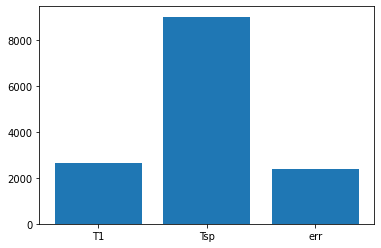

In [10]:
# Create new feature: setpoint error
df['err'] = df['Tsp'] - df['T1']

# Load possible features
X = df[['T1','Tsp','err']]
y = np.ravel(df[['Q1']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
plt.bar(x=X.columns,height=fit.scores_);

### Feature selection, scaling, and formatting data to LSTM input format

In [11]:
X = df[['Tsp','err']].values
y = df[['Q1']].values

# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
window = 15
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.2,shuffle=False)

### Keras LSTM 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

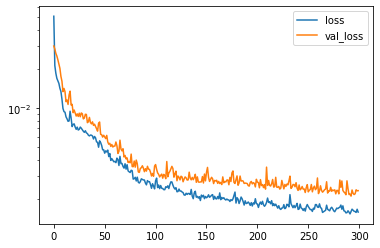

In [12]:
# Keras LSTM model
model = Sequential()

# First layer specifies input_shape and returns sequences
model.add(LSTM(units=100, return_sequences=True, 
               input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
# Dropout layer to prevent overfitting
model.add(Dropout(rate=0.1))

# Last layer doesn't return sequences (middle layers should return sequences)
model.add(LSTM(units=100))
model.add(Dropout(rate=0.1))

# Dense layer to return prediction
model.add(Dense(1))

# Compile model; adam optimizer, mse loss
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.2,
                   callbacks = [TqdmCallback(verbose=1)],#es
                   batch_size=100,
                   epochs=300)

# Plot loss and save model
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('lstm_control.h5')

### Preliminary model performance assessment

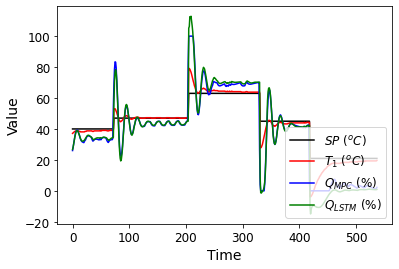

In [13]:
# Predict using LSTM
yp_s = model.predict(Xtest)

# Unscale data
Xtest_us = s_x.inverse_transform(Xtest[:,-1,:])
ytest_us = s_y.inverse_transform(ytest)
yp = s_y.inverse_transform(yp_s)

# Derive Tsp (sp) and T1 (pv) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]

# Plot SP, MPC response, and LSTM response
plt.plot(sp,'k-',label='$SP$ $(^oC)$')
plt.plot(pv,'r-',label='$T_1$ $(^oC)$')
plt.plot(ytest_us,'b-',label='$Q_{MPC}$ (%)')
plt.plot(yp,'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=12,loc='lower right')
plt.xlabel('Time',size=14)
plt.ylabel('Value',size=14)
plt.xticks(size=12)
plt.yticks(size=12);

### Generate SP data for test

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


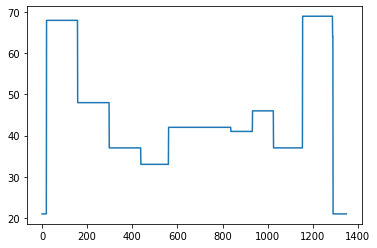

In [14]:
# Run time in minutes
run_time = 45.0

# Number of cycles
loops = int(30.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
T2 = np.zeros(loops)
Q1mpc = np.zeros(loops) # Heater values for MPC controller
Q2mpc = np.zeros(loops)
Qlstm = np.zeros(loops) # Heater values for LSTM controller
tm = np.linspace(0,2*(loops-1),loops) # Time

# Temperature set point (degC)
with mlab() as lab:
    Tsp1 = np.ones(loops) * lab.T1
    Tsp2 = np.ones(loops) * lab.T2

# vary temperature setpoint
end = window + 5 # leave 1st window + 10 seconds of temp set point as room temp
while end <= loops: 
    start = end
    # keep new temp set point value for anywhere from 3 to 5 min
    end += random.randint(90,150) 
    Tsp1[start:end] = random.randint(30,70)
    
# leave last 120 seconds as room temp
Tsp1[-60:] = Tsp1[0]
plt.plot(Tsp1)
plt.show()

### Part A: Run the controller with the MPC, but also output the LSTM for comparison

In [15]:
# LSTM Controller
def lstm(T1_m, Tsp_m):
    # Calculate error (necessary feature for LSTM input)
    err = Tsp_m - T1_m
    
    # Format data for LSTM input
    X = np.vstack((Tsp_m,err)).T
    Xs = s_x.transform(X)
    Xs = np.reshape(Xs, (1, Xs.shape[0], Xs.shape[1]))
    
    # Predict Q for controller and unscale
    Q1c_s = model.predict(Xs)
    Q1c = s_y.inverse_transform(Q1c_s)[0][0]
    
    # Ensure Q1c is between 0 and 100
    Q1c = np.clip(Q1c,0.0,100.0)
    return Q1c

In [16]:
# Run test
with mlab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    t1 = time.time()
    for i in range(loops):
        t2 = time.time()
        
        if tclab_hardware:
            if tm[i]>=(t2-t1):
                time.sleep(max(0,min(2,tm[i]-(t2-t1))))
        else:
            dt = time.time()-t2
            for t in tclab.clock(2, max(0.1,2-dt)):
                continue
            t2=time.time()
               
        # Read temperatures in Celcius 
        T1[i] = lab.T1; T2[i] = lab.T2

        # Calculate MPC output every 2 sec
        try:
            [Q1mpc[i],Q2mpc[i]] = mpc(m,T1[i],Tsp1[i],T2[i],Tsp2[i])
        except:
            Q1mpc[i]=0; Q2mpc[i]=0
        # Write heater output (0-100)
        lab.Q1(Q1mpc[i])
        lab.Q2(Q2mpc[i])
         
        if i%p1==0:            
            print('  Time_____Q1___Tsp1_____T1')
        if i%p2==0:
            print(('{:6.1f} {:6.2f} {:6.2f} {:6.2f}').format( \
                      tm[i],Q1mpc[i],Tsp1[i],T1[i]))
        
        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp1[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(T1_m,Tsp_m)
            
        prev_time = t

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.95 °C
  Time_____Q1___Tsp1_____T1
   0.0   6.27  20.95  20.95
  40.0  81.97  68.00  22.24
  80.0  50.76  68.00  64.46
 120.0  70.64  68.00  62.85
 160.0  75.88  68.00  63.82
 200.0  74.31  68.00  65.10
 240.0  75.52  68.00  65.43
 280.0  75.57  68.00  66.07
 320.0   0.00  48.00  65.10
 360.0  28.55  48.00  50.60
  Time_____Q1___Tsp1_____T1
 400.0  51.56  48.00  48.34
 440.0  48.31  48.00  48.99
 480.0  45.84  48.00  48.99
 520.0  45.72  48.00  48.67
 560.0  46.08  48.00  48.34
 600.0   0.00  37.00  47.70
 640.0  19.39  37.00  39.32
 680.0  31.43  37.00  38.03
 720.0  30.20  37.00  38.03
 760.0  27.74  37.00  38.03
  Time_____Q1___Tsp1_____T1
 800.0  27.98  37.00  37.71
 840.0  27.16  37.00  37.71
 880.0   4.05  33.00  37.06
 920.0  19.17  33.00  33.52
 960.0  24.24  33.00  33.52
1000.0  22.10  33.00  33.52
1040.0  20.80  33.00  33.52
1080.0  20.72  33.00  33.20
1120.0  20.96  33.00  33.52
1160.0  53.98  42.00

[]

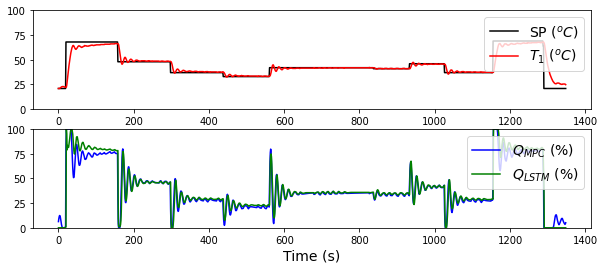

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(Tsp1[:i],'k-',label='SP $(^oC)$')
plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
plt.legend(loc='upper right',fontsize=14)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.subplot(2,1,2)
plt.plot(Q1mpc[:i],'b-',label='$Q_{MPC}$ (%)')
plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
plt.legend(loc='upper right',fontsize=14)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.plot()

### Part B: Run the controller with just the LSTM

In [ ]:
# Run test
with mlab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    t1 = time.time()
    for i in range(loops):
        t2 = time.time()
        
        if tclab_hardware:
            if tm[i]>=(t2-t1):
                time.sleep(max(0,min(2,tm[i]-(t2-t1))))
        else:
            dt = time.time()-t2
            for t in tclab.clock(2, max(0.1,2-dt)):
                continue
            t2=time.time()

        # Read temperatures in Celcius 
        T1[i] = lab.T1; T2[i] = lab.T2

        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp1[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(T1_m,Tsp_m)
            
        if i%p1==0:            
            print('  Time_____Q1___Tsp1_____T1')
        if i%p2==0:
            print(('{:6.1f} {:6.2f} {:6.2f} {:6.2f}').format( \
                      tm[i],Qlstm[i],Tsp1[i],T1[i]))

        # Write heater output (0-100)
        lab.Q1(Qlstm[i])

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.95 °C
  Time_____Q1___Tsp1_____T1
   0.0   0.00  20.95  20.95
  40.0   1.23  68.00  20.95
  80.0  96.11  68.00  40.61
 120.0 100.00  68.00  59.95
 160.0  77.23  68.00  65.75
 200.0  77.28  68.00  66.72
 240.0  77.32  68.00  67.04
 280.0  77.18  68.00  67.36
 320.0   1.69  48.00  67.36
 360.0  56.97  48.00  51.89
  Time_____Q1___Tsp1_____T1
 400.0  47.62  48.00  51.25
 440.0  47.17  48.00  50.28
 480.0  47.38  48.00  49.63
 520.0  46.92  48.00  49.31
 560.0  46.42  48.00  48.99
 600.0   0.89  37.00  48.67
 640.0  35.83  37.00  40.29
 680.0  30.11  37.00  39.97
 720.0  30.06  37.00  39.32
 760.0  30.24  37.00  39.00
  Time_____Q1___Tsp1_____T1
 800.0  29.42  37.00  38.68
 840.0  29.33  37.00  38.68
 880.0  13.00  33.00  38.68
 920.0  24.86  33.00  35.78
 960.0  23.09  33.00  35.45
1000.0  23.19  33.00  35.13
1040.0  23.48  33.00  34.81
1080.0  23.05  33.00  34.81
1120.0  23.05  33.00  34.81
1160.0  23.20  42.00

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(Tsp1[:i],'k-',label='SP $(^oC)$')
plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=14)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

### Part C

Use the LSTM controller to control the [TCLab microcontroller](https://apmonitor.com/heat.htm) or [Emulated TCLab](https://tclab.readthedocs.io/en/latest/notebooks/04_Emulation_of_TCLab_for_Offline_Use.html) from a separate program. Demonstrate that you can [package and deploy the LSTM model](https://apmonitor.com/pds/index.php/Main/DeployMachineLearning) so that it could be used on a different computer than the training computer. The application does not necessarily need to run on a separate computer, but show that it is a separate program and independent of this training notebook.

<img align=left width=150px src='https://apmonitor.com/pds/uploads/Main/deploy_machine_learning.png'>

<img align=left width=400px src='https://apmonitor.com/pdc/uploads/Main/tclab_connect.png'>

In [ ]:
import pickle
# export model name and scaling
z = ['lstm_control.h5',s_x,s_y,window]
pickle.dump(z,open('lstm_control.pkl','wb'))